<a href="https://colab.research.google.com/github/shoaibwaheed/finance/blob/main/profolio_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
! pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [5]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import os
import yfinance as yf
import scipy.optimize as spo
import copy

In [50]:
def get_data(symbols, addSPY, sd,ed):
    """Read stock data (adjusted close) for given symbols from CSV files."""

    if addSPY:
      symbols.append('SPY')
      data = yf.download(symbols,period = '1d',start=sd, end=ed)
    else:
      data = yf.download(symbols,period = '1d',start=sd, end=ed)
    data = data['Adj Close']
    #print(data)
    return data

def plot_data(df, title="Stock prices", xlabel="Date", ylabel="Price"):
    import matplotlib.pyplot as plt

    """Plot stock prices with a custom title and meaningful axis labels."""

    ax = df.plot(title=title, fontsize=12)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()

In [7]:
 get_data(symbols=['qcom','goog'],addSPY=False, sd='2021-1-1',ed='2022-1-1')

[*********************100%***********************]  2 of 2 completed


,GOOG,QCOM
Date,,
2021-01-04,86.412003,143.640305
2021-01-05,87.045998,147.441666
2021-01-06,86.764503,146.242279
2021-01-07,89.362503,150.604675
2021-01-08,90.360497,151.513916
...,...,...
2021-12-27,148.063995,183.554291
2021-12-28,146.447998,182.066788
2021-12-29,146.504501,183.426208


[*********************100%***********************]  16 of 16 completed


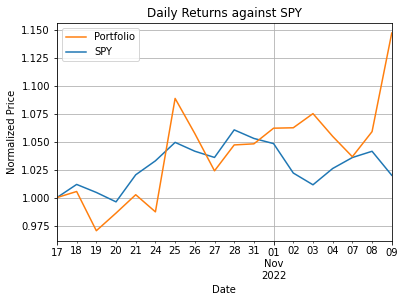

Start Date:           2022-10-15
End Date:             <class 'prompt_toolkit.enums.EditingMode'>
Symbols:              ['pltr', 'ttd', 'cyrx', 'twks', 'Nex', 'vrna', 'insm', 'tsha', 'crox', 'srne', 'bnft', 'rig', 'pfe', 'mack', 'abeo', 'SPY']
Allocations:          [0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667]
Sharpe Ratio:         3.7373934212739877
Volatility:           0.03707639563294488
Average Daily Return: 0.008729031368369156
Cumulative Return:    0.1471013595414956


In [8]:
from prompt_toolkit.filters.app import EditingMode
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import os




def assess_portfolio(
    sd, ed , \
    syms, \
    allocs=[0.1,0.2,0.3,0.4], \
    sv=1000000, rfr=0.0, sf=252.0, \
    gen_plot=False):
    
    """
    sd = Start date (datetime format)
    ed = End date (datetime format)
    syms = List of symbols
    alllocs = allocation of syms, sums to 1.0
    sv = starting value (dollars)
    rfr = Risk free return
    sf = sampling frequency 
    """
    addSPY=True
    # read in adjusted closing prices for given symbols, date range
    # adding SPY to allocation for calulations and trading days
    
    df_all = get_data(syms,addSPY, sd,ed)  # automatically adds SPY
    #print(df_all)
    #print('rt')
    df = df_all.copy()
    #print(df.shape)
    df = df.drop(['SPY'], axis=1)
    
    df_SPY = df_all['SPY']
    
    #print(syms)
    #print(";;;")

    # get daily portfolio value    
    df_nrm          = df / df.iloc[0] 
    allocated       = df_nrm * allocs
    position_values = allocated * sv
    port_value      = position_values.sum(axis = 1)
    
    # daily returns (y_{t} = x_{t}/x_{t-1} - 1
    d_returns       = port_value.copy() 
    d_returns       = (port_value/port_value.shift(1) - 1)[1:]
    
    # Below are desired output values
    
    # cumulative return (final - initial) - 1
    cr   = port_value[-1] / port_value[0] - 1
    # average daily return
    adr  = d_returns.mean()
    # standard deviation of daily return
    sddr = d_returns.std()
    # sharpe ratio ((Mean - Risk free rate)/Std_dev)
    daily_rfr     = (1.0 - rfr)**(1/252) - 1 #Should this be sampling freq instead of 252? 
    sr            = (d_returns - daily_rfr).mean() / sddr
    sr_annualized = sr * (sf**0.5)
    
    # compare daily portfolio value with SPY using a normalized plot
    if gen_plot:
        df_nrm_SPY = df_SPY / df_SPY.iloc[0]
        
        port_value_norm = port_value / port_value.iloc[0]
        port_vs_SPY = df_nrm_SPY.copy()
        port_vs_SPY = port_vs_SPY.to_frame().join(port_value_norm.to_frame('Portfolio'))
    
        ax_portfolio = port_vs_SPY.plot(title = 'Daily Returns against SPY', grid = True, legend = 'reverse')
        ax_portfolio.set_xlabel('Date')
        ax_portfolio.set_ylabel('Normalized Price')
        plt.show()
    
    # end value
    ev = port_value[-1]
    
    return cr, adr, sddr, sr_annualized, ev

def test_code():
    # This code WILL NOT be tested by the auto grader
    # It is only here to help you set up and test your code

    # Define input parameters
    # Note that ALL of these values will be set to different values by
    # the autograder!
    sd = '2022-10-15'
    ed = '2022-11-10'
    symbols = ['pltr','ttd','cyrx','twks','Nex','vrna','insm','tsha','crox','srne','bnft','rig','pfe','mack','abeo']
    allocations = [(1/len(symbols))] * len(symbols)
    #allocations = [0.5,0.5]
    start_val = 1000  
    risk_free_rate = 0.0
    sample_freq = 252

    # Assess the portfolio
    cr, adr, sddr, sr, ev = assess_portfolio(sd, ed,\
        syms = symbols, \
        allocs = allocations,\
        sv = start_val, \
        rfr = risk_free_rate, \
        sf = sample_freq, \
        gen_plot = True)

    # Print statistics
    print("Start Date:          ", sd)
    print("End Date:            ", EditingMode)
    print("Symbols:             ", symbols)
    print("Allocations:         ", allocations)
    print("Sharpe Ratio:        ", sr)
    print("Volatility:          ", sddr)
    print("Average Daily Return:", adr)
    print("Cumulative Return:   ", cr)
    
if __name__ == "__main__":
    test_code()


In [56]:
def compute_sddr(alloc, df_norm):

    allocation = df_norm * alloc
    portfolio  = allocation.sum(axis = 1)
    #Compute daily returns below
    d_returns       = portfolio.copy()
    d_returns       = (portfolio / portfolio.shift(1)) - 1
    d_returns.iloc[0] = 0
    
    return(d_returns.std())   


def optimize_portfolio(sd, ed, \
    syms, gen_plot=False):
    """Inputs:
           sd       = start date
           ed       = end date
           syms     = ticker symbols
           gen_plot = Boolean to generate a plot
       Output:
           allocs = Allocation
           cr   = cumulative return
           adr  = average daily rate of return
           sddr = standard deviation of daily return
           sr   = sharpe ratio
    """
    addSPY = False
    prices_all = get_data(syms,addSPY, sd,ed)  # automatically adds SPY
    
    df = copy.deepcopy(prices_all)
    
    if 'SPY' in df.columns:
      df = df.drop(['SPY'], axis=1)
      df_SPY = prices_all['SPY']
    

    start_val = 1000  
    risk_free_rate = 0.0
    sample_freq = 252  
    

    df_norm = df / df.iloc[0]
    

    allocs_i = [1./len(syms)] * len(syms) #Initial conditions for minimizer function
    boundary_c = ([0., 1.],) * len(syms) #Boundary condition for allocation values    


    allocs = spo.minimize(compute_sddr, allocs_i, args = (df_norm,), method = 'SLSQP',\
                             options={'disp' : True}, bounds= boundary_c, \
                             constraints = ({'type':'eq', 'fun' : lambda allocs : 1.0 - allocs.sum()})) #Constrain expected output

                             

    
    print(df.shape)
    print(allocs)    
    # find the allocations for the optimal portfolio
    cr, adr, sddr, sr,ev = assess_portfolio(sd, ed, syms, allocs.x, 1,risk_free_rate,sample_freq, gen_plot = gen_plot)

    return allocs.x, cr, adr, sddr, sr

[*********************100%***********************]  2 of 2 completed
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.010101515811956958
            Iterations: 4
            Function evaluations: 12
            Gradient evaluations: 4
(2, 2)
     fun: 0.010101515811956958
     jac: array([-0.        ,  0.06546721])
 message: 'Optimization terminated successfully'
    nfev: 12
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([1.00000000e+00, 1.11022302e-16])
[*********************100%***********************]  3 of 3 completed


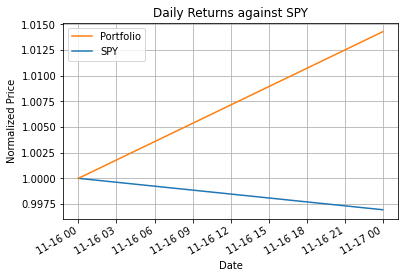

Start Date:           2022-11-16
End Date:             2022-11-18
Symbols:              ['grph', 'lctx', 'SPY']
Allocations:          [1.00000000e+00 1.11022302e-16]
Allocations sum:          1.0
Sharpe Ratio:         nan
Volatility:           nan
Average Daily Return: 0.014285700661795797
Cumulative Return:    0.014285700661795797


In [74]:
def test_code():
    # This function WILL NOT be called by the auto grader
    # Do not assume that any variables defined here are available to your function/code
    # It is only here to help you set up and test your code

    # Define input parameters
    # Note that ALL of these values will be set to different values by
    # the autograder!

    sd = '2022-11-16'
    ed = '2022-11-18'
    #symbols = ['pltr','ttd','cyrx','twks','Nex','vrna','insm','tsha','crox','srne','bnft','rig','pfe','mack','abeo']
    symbols = ['grph','lctx']
    # Assess the portfolio
    allocations, cr, adr, sddr, sr = optimize_portfolio(sd = sd, ed = ed,\
        syms = symbols, \
        gen_plot = True)

    print("Start Date:          ", sd)
    print("End Date:            ", ed)
    print("Symbols:             ", symbols)
    print("Allocations:         ", allocations)
    print("Allocations sum:         ", sum(allocations))
    print("Sharpe Ratio:        ", sr)
    print("Volatility:          ", sddr)
    print("Average Daily Return:", adr)
    print("Cumulative Return:   ", cr)
if __name__ == "__main__":
    test_code()